# Methodology
This notebook visualizes the method used to assign RSV cases to cohorts.

It relies on a simple assumption that cases in the very young can be backdated to the period when the patient was likely born.

For example, if a child in the ´6-11 months´ age group was admitted/tested in Week 13,2020, it is assumed equally likely to have been born in any of the weeks 14-40, 2019.

This assumption is not strictly plausible since children are more at risk the younger they are, especially so for admissions due to bronchiolitis. The effect can be seen in the following diagram, which displays a "blocky" quality, where it should likely look more like exponential curves.

However, this limitation probable only distorts the result marginally, when grouping patients by calendar year.
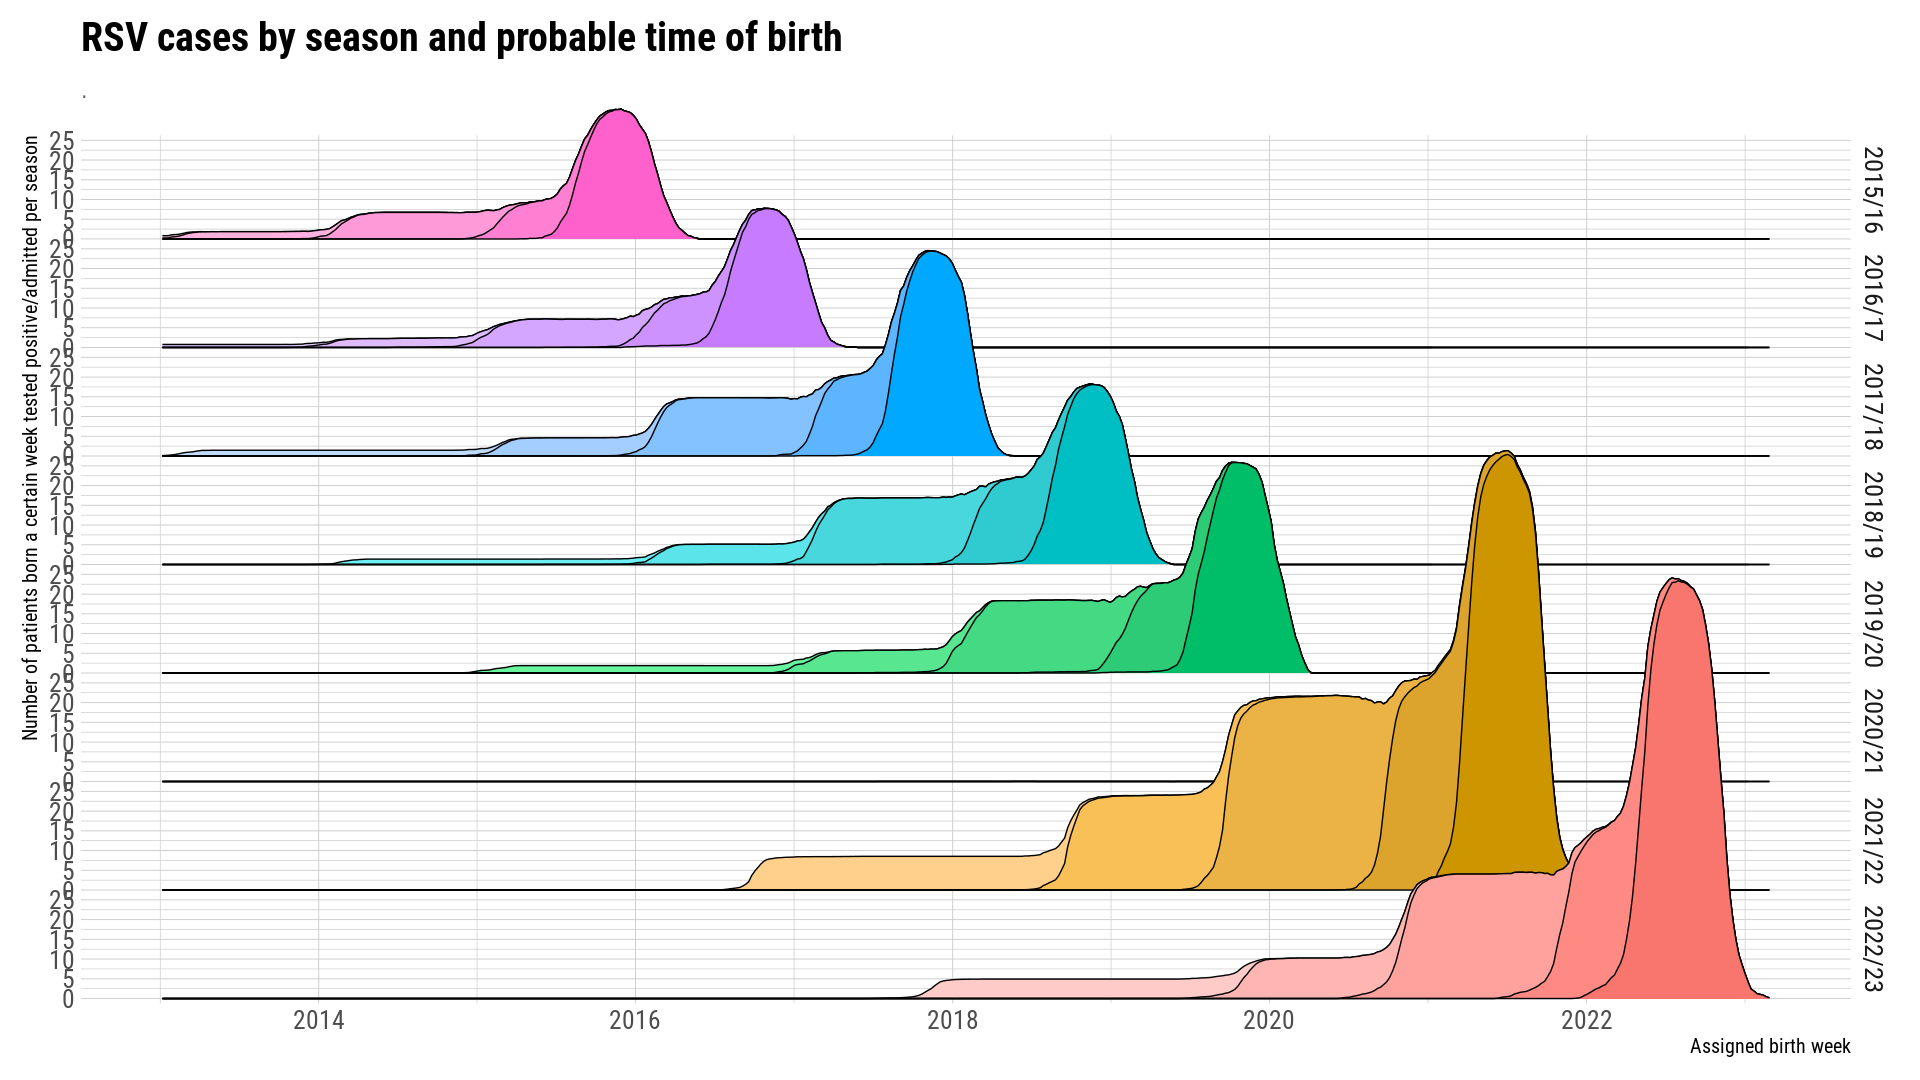

In [16]:
source("common.R")

age_groups <- c("0-5 months", "6-11 months",  "1 year olds", "2 year olds", "3-5 years")
n_age_groups <- 5
age_groupname = "under six year olds"

df <- read_data()%>%
  filter(`Age Group` %in% age_groups) 

last_date <- max((df%>%filter(value!=0))$Date)

caption = paste("Plot by @bjornpiltz | Source: Statens Serum Institut,", last_date)

df %>%
  tail

Year,Week,Age Group,Season,type,value,Date
<dbl>,<int>,<fct>,<chr>,<chr>,<dbl>,<date>
2025,52,3-5 years,2021/22,tested,0,2025-12-28
2025,52,3-5 years,2022/23,admissions,0,2025-12-28
2025,52,3-5 years,2022/23,cases,0,2025-12-28
2025,52,3-5 years,2022/23,deaths,0,2025-12-28
2025,52,3-5 years,2022/23,incidens,0,2025-12-28
2025,52,3-5 years,2022/23,tested,0,2025-12-28


## Backdating
This part visualizes the backdating, i.e patients in the 6-11 months group are backdated by 26 weeks and spread out over a 26 week period.

Warning message:
“Removed 944 rows containing non-finite values (`stat_align()`).”


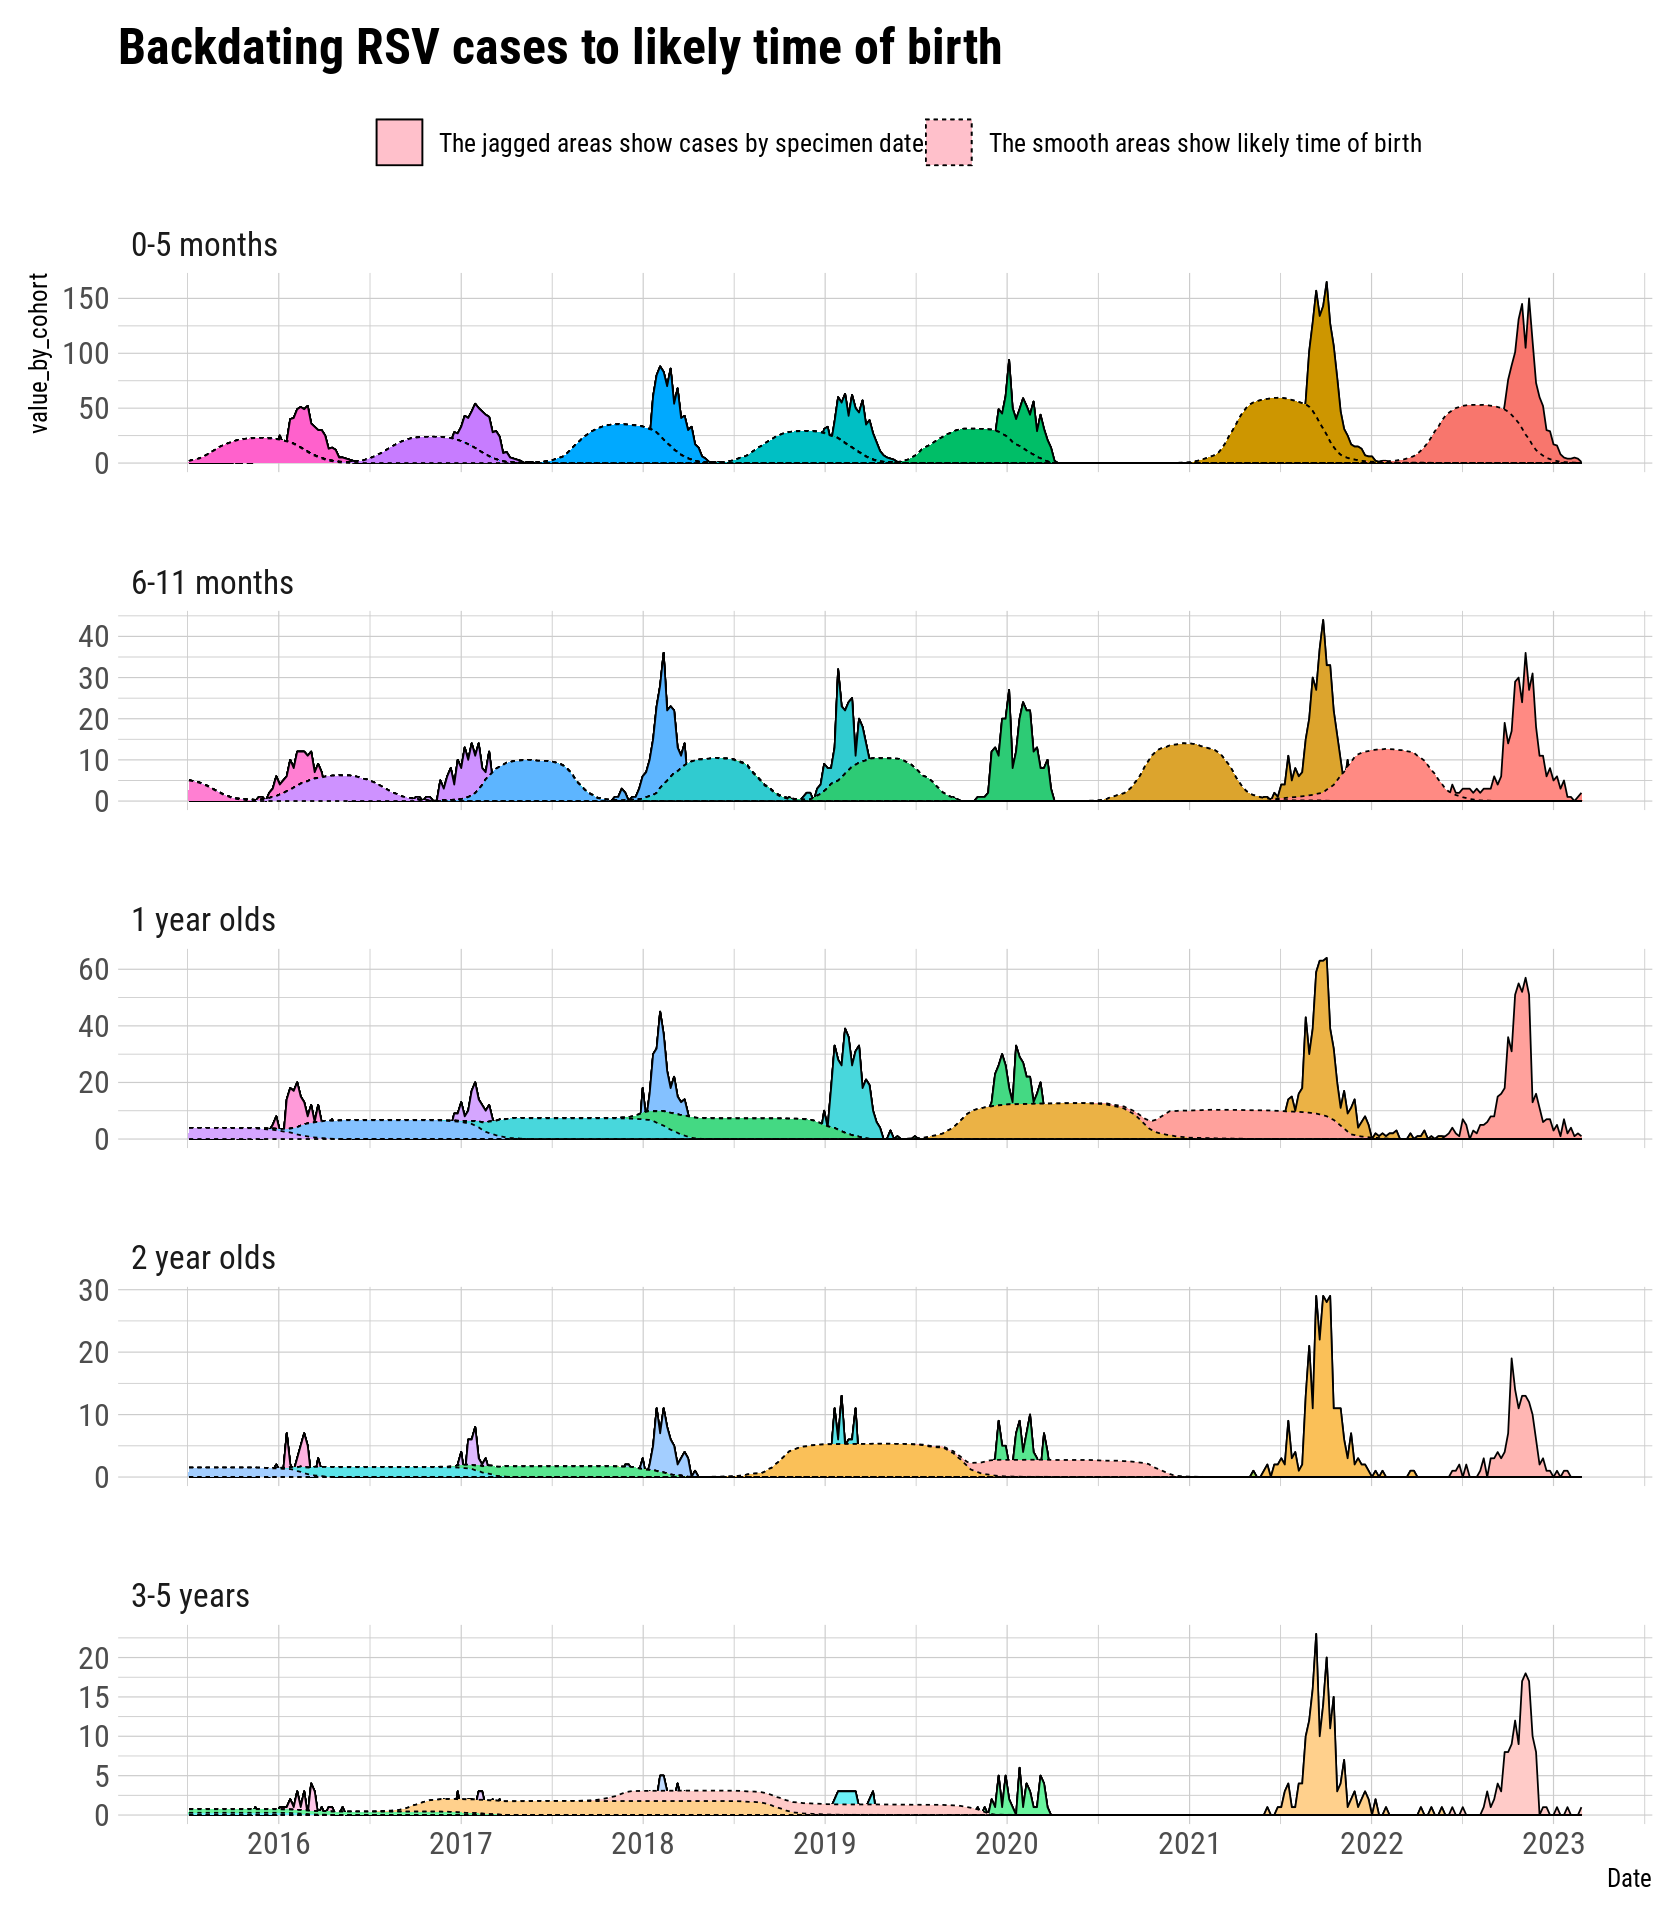

In [17]:
s = 1.2
options(repr.plot.width = s*7, repr.plot.height = s*8, repr.plot.res = 240/s)

df2 <-
  df%>%
  group_by(`Age Group`, Season, type)%>%
  arrange(Year, Week)%>%
  mutate(value_by_cohort = case_when(`Age Group`=="0-5 months" ~  lead(zoo::rollmean(value, k = 26, na.pad = T, align = "left"), 0),
                                     `Age Group`=="6-11 months" ~ lead(zoo::rollmean(value, k = 26, na.pad = T, align = "left"), 26),
                                     `Age Group`=="1 year olds" ~ lead(zoo::rollmean(value, k = 52, na.pad = T, align = "left"), 52),
                                     `Age Group`=="2 year olds" ~ lead(zoo::rollmean(value, k = 52, na.pad = T, align = "left"), 104),
                                     `Age Group`=="3-5 years"   ~ lead(zoo::rollmean(value, k = 104, na.pad = T, align = "left"), 156),
                                                              T ~ value))%>%
  mutate(Date = ISOweek::ISOweek2date(paste0(Year, "-W", str_pad(Week, 2, pad = "0"), "-7")))

df2%>%
  filter(type == "admissions")%>%
  filter(Date>="2015-07-01" & Date<=last_date)%>%
  group_by(Date, `Age Group`, Season)%>%
  summarise(value_by_cohort = sum(value_by_cohort),
            value = sum(value), 
            .groups = "drop")%>%
  ggplot(aes(x = Date, y = value_by_cohort,
            fill = interaction(fct_rev(`Age Group`), fct_rev(Season)))) +
  labs(title = "Backdating RSV cases to likely time of birth", linetype = "") +
  geom_area(aes(y = value, linetype = "The jagged areas show cases by specimen date"), color = "black", size = 0.3) +
  geom_area(aes(y = value_by_cohort, linetype = "The smooth areas show likely time of birth"), color = "black", size = 0.3) +
  scale_fill_manual(values = fill_colors_inverse(n_age_groups)) +
  scale_x_date(date_breaks = "1 years", date_labels = "%Y") +
  guides(fill = FALSE) +
  guides(linetype = guide_legend(override.aes = list(fill = c("pink") ) ) ) +
  facet_wrap(~`Age Group`, ncol = 1, scale = "free_y") +
  theme(legend.position = "top")

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“Removed 848 rows containing non-finite values (`stat_align()`).”
Warning message:
“Removed 848 rows containing non-finite values (`stat_align()`).”


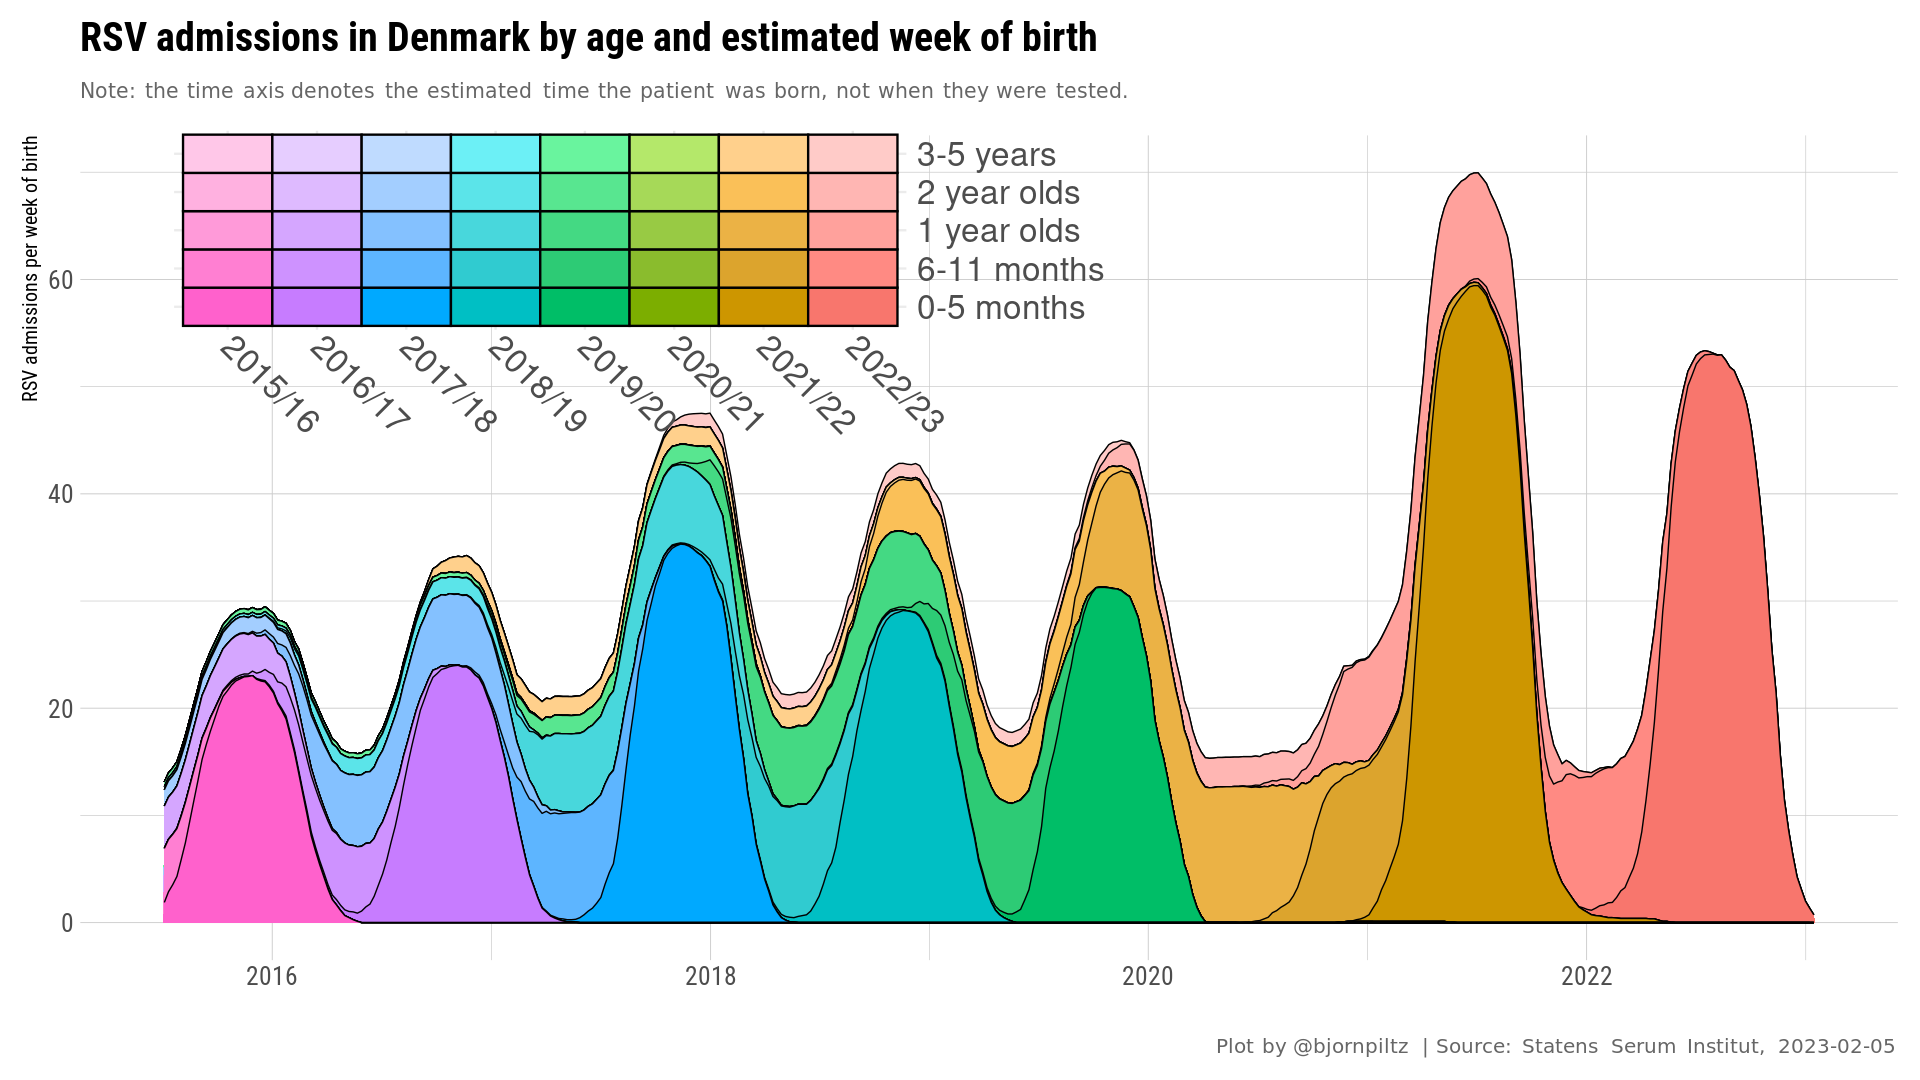

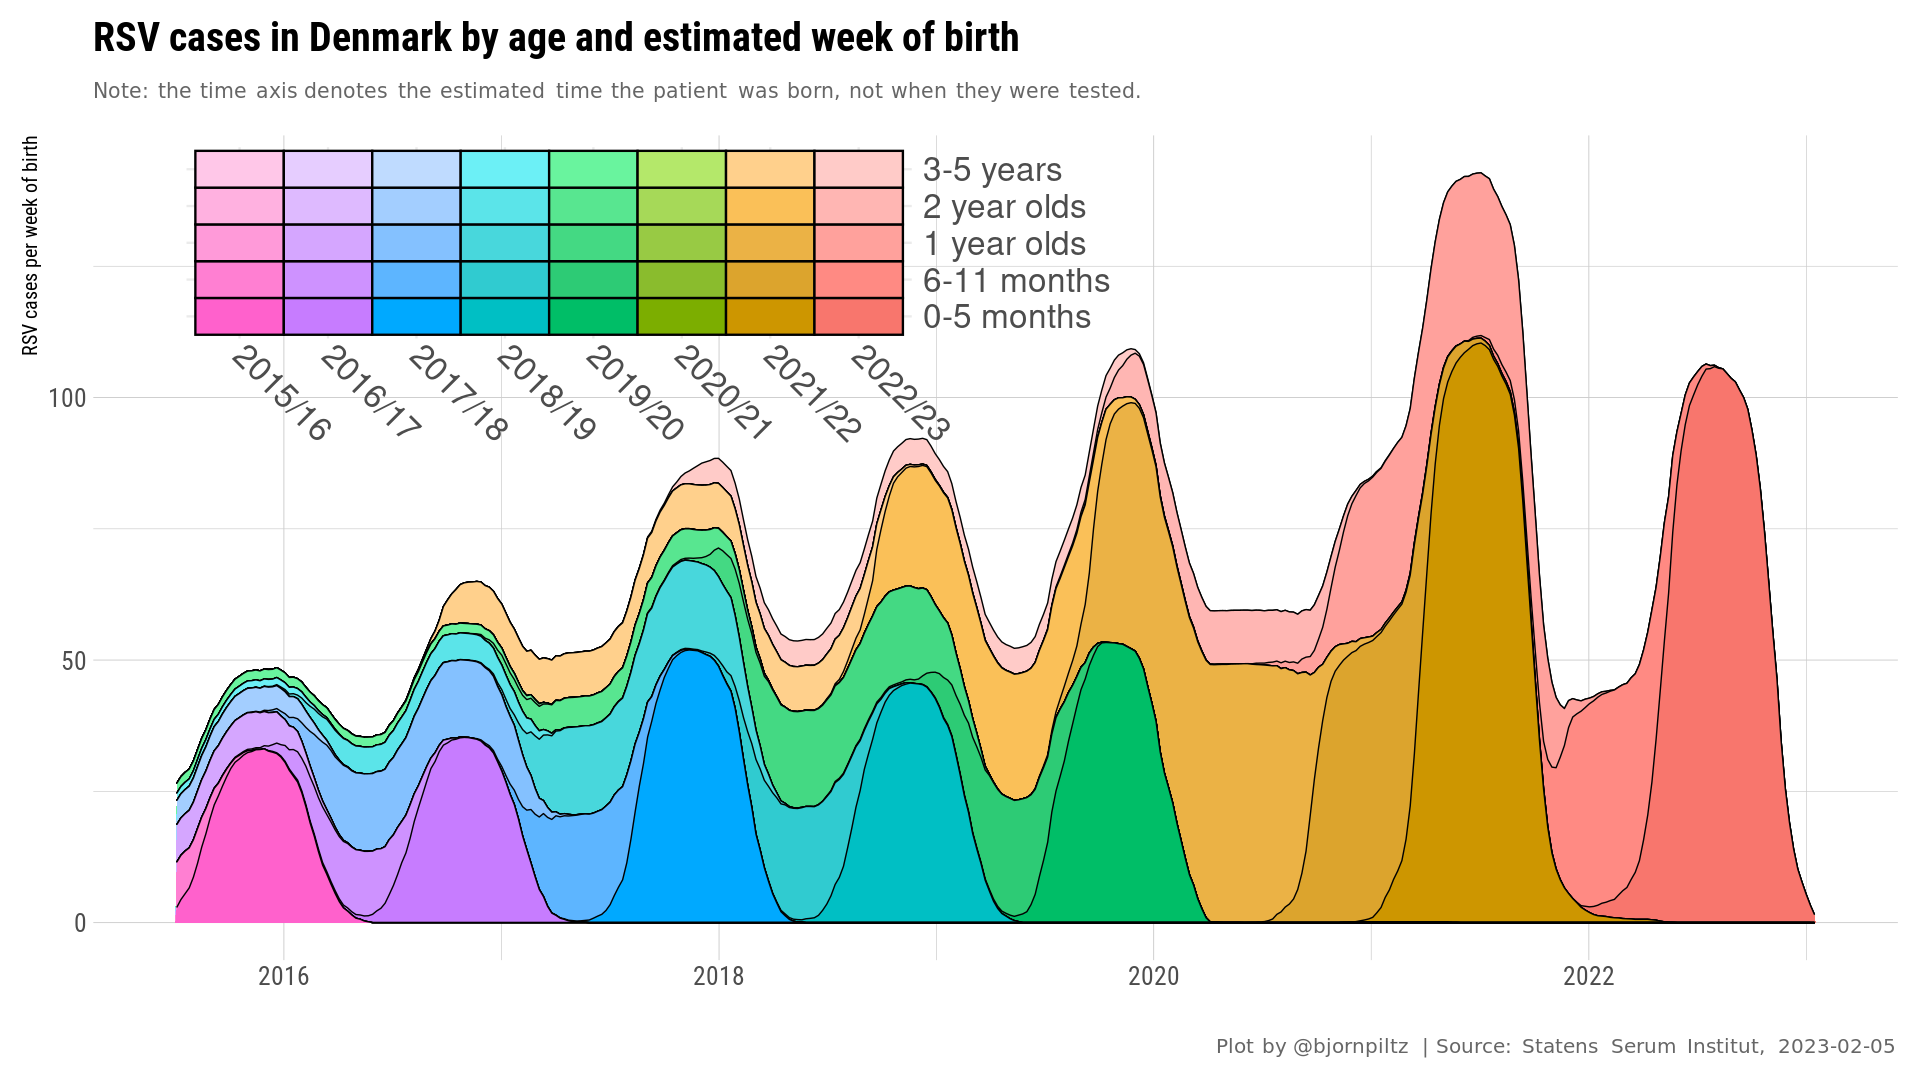

In [4]:
s = 1.5
options(repr.plot.width = s*8, repr.plot.height = s*4.5, repr.plot.res = 240/s)

plot_cohorts <- function(type_, scale=1){
  df2%>%
  filter(type == type_)%>%
  group_by(Date, Season, `Age Group`)%>%
  summarise(value_by_cohort = sum(value_by_cohort),
           .groups = "drop")%>%
  filter(Date>="2015-07-01" & Date<"2023-01-21")%>%
  arrange(Season)%>%
  ggplot(aes(x = Date, y = value_by_cohort)) +
  labs(title = paste("RSV", type_, "in Denmark by age and estimated week of birth"), 
       subtitle = "Note: the time axis denotes the estimated time the patient was born, not when they were tested.",
       caption = caption, fill = "", x = "", y = paste("RSV", type_, "per week of birth")) +
  geom_area(aes(fill = interaction(fct_rev(`Age Group`), fct_rev(Season))), color = "black", size = 0.3) +
  scale_fill_manual(values = fill_colors_inverse(n_age_groups)) +
  theme(legend.position = "none")+
  guides(fill=guide_legend(ncol=4))+
  annotation_custom(ggplotGrob(plot_inset(n_age_groups)), 
                    xmin = as.Date("2015-07-01"), 
                    xmax = as.Date("2020-01-01"), 
                    ymin = 40*scale, ymax = 75*scale)
}
plot_cohorts("admissions")
plot_cohorts("cases", 2)

Warning message:
“Removed 944 rows containing non-finite values (`stat_align()`).”
Warning message:
“Removed 944 rows containing non-finite values (`stat_align()`).”


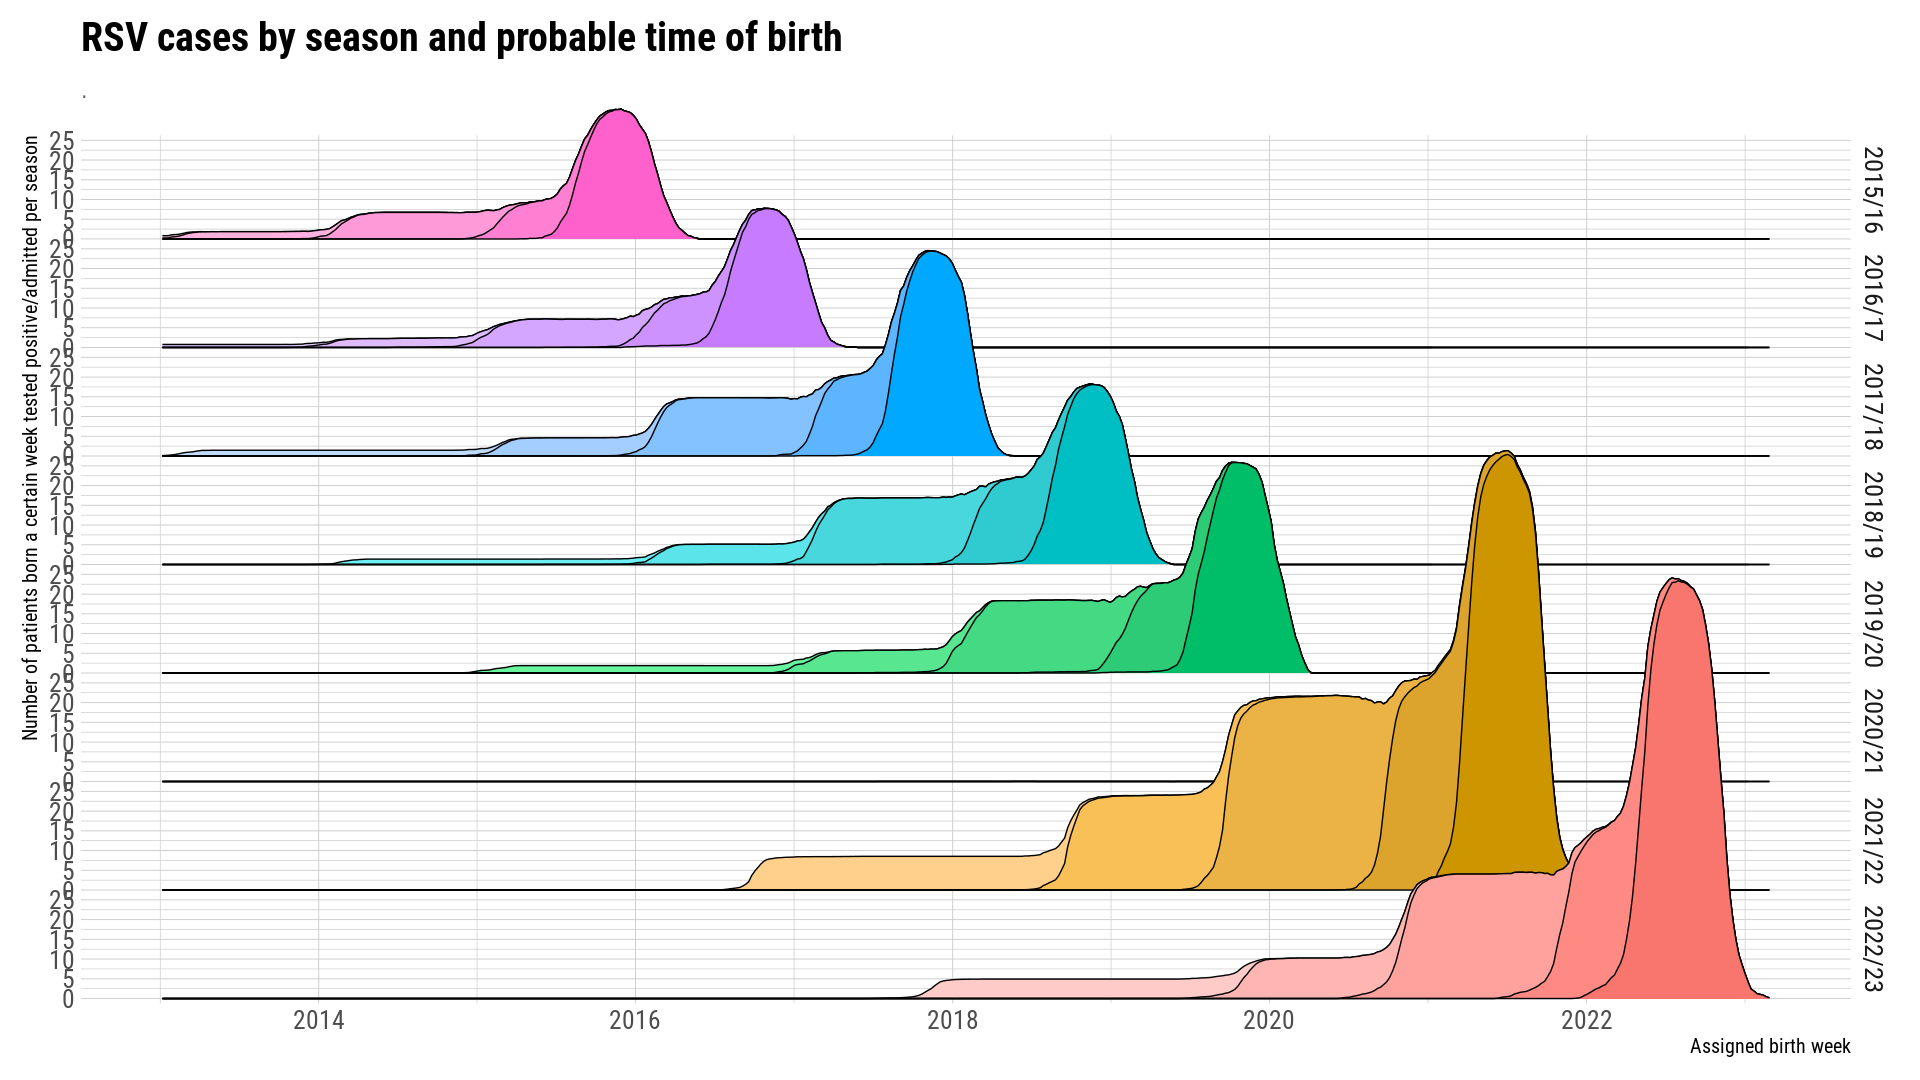

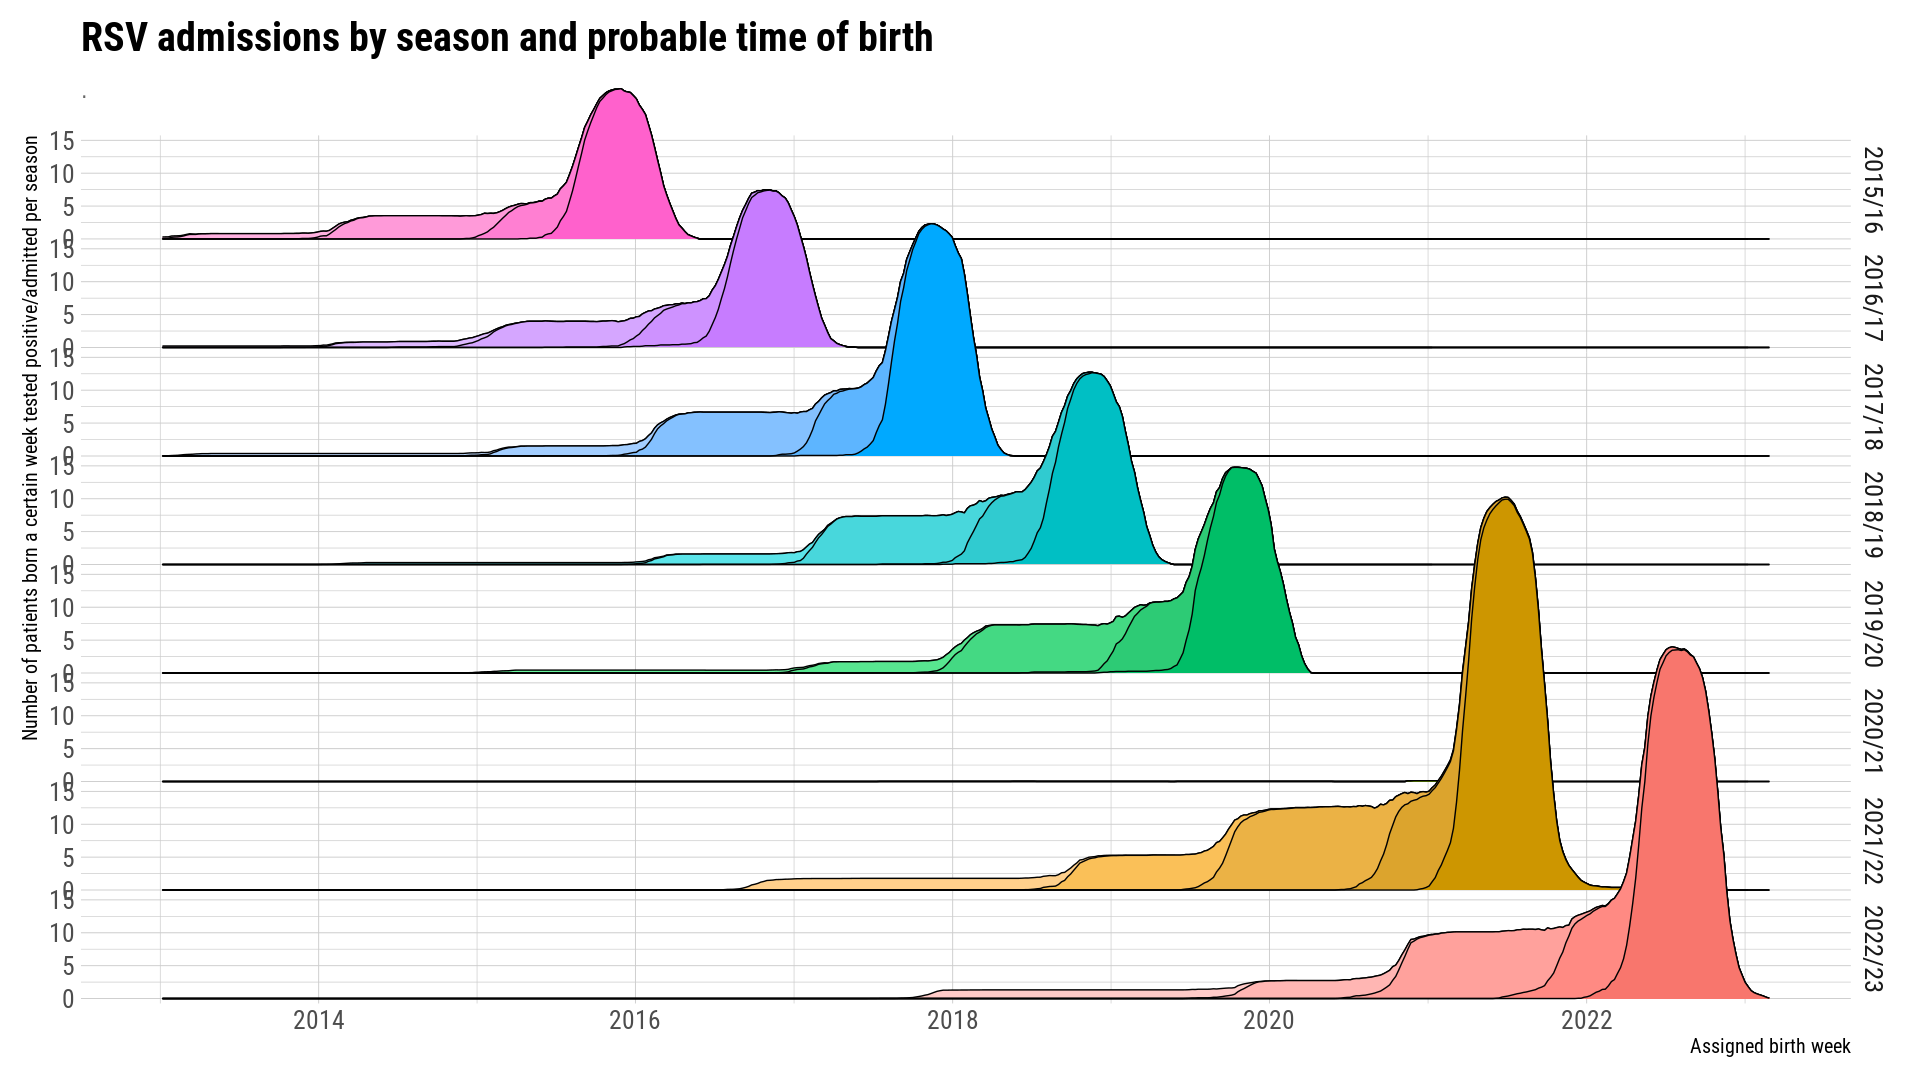

In [15]:
s = 1.5
options(repr.plot.width = s*8, repr.plot.height = s*4.5, repr.plot.res = 240/s)

tba <- function(type_, scale){
    df2%>%
      filter(type == type_)%>%
      group_by(Date, Season, `Age Group`)%>%
      summarise(value_by_cohort = sum(value_by_cohort),
                .groups = "drop")%>%
      filter(Date>="2013-01-01" & Date<=last_date)%>%
      arrange(Season)%>%
      ggplot(aes(x = Date, y = value_by_cohort)) +
      labs(title = paste("RSV", type_, "by season and probable time of birth"), subtitle = ".",
           x = "Assigned birth week", y = "Number of patients born a certain week tested positive/admitted per season") +
      geom_area(aes(fill = interaction(fct_rev(`Age Group`), fct_rev(Season))), color = "black", size = 0.3)+
      scale_fill_manual(values = fill_colors_inverse(n_age_groups)) +
      facet_grid(Season~.) +
      scale_y_continuous(breaks = seq(0, 100, 5)) +
      coord_cartesian(ylim = c(0, scale), clip = "off") +
      theme(legend.position = "none",
            panel.spacing = unit(0, "lines")) 
}
tba("cases", 25)
tba("admissions", 15)